In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
import psycopg2
from psycopg2 import sql

# Define your connection parameters
conn_params = {
    'dbname': 'postgres',
    'user': 'adminadmin',
    'password': 'InsightJDE03',
    'host': 'jde03.postgres.database.azure.com',
    'port': '5432'
}

# Establish a connection to the database
conn = psycopg2.connect(**conn_params)

# Create a cursor object
cursor = conn.cursor()

# Execute a simple SQL query
cursor.execute("SELECT version();")

# Fetch and print the result of the query
db_version = cursor.fetchone()
print(f"Connected to: {db_version}")

# Close the cursor and connection
cursor.close()
conn.close()



Connected to: ('PostgreSQL 16.2 on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0, 64-bit',)


In [3]:
# Establish a connection to the database
conn = psycopg2.connect(**conn_params)

# Create a cursor object
cursor = conn.cursor()

# SQL query to retrieve all table names
cursor.execute("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
""")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])

# SQL query to retrieve column information for each table
print("\nColumns in each table:")
for table in tables:
    cursor.execute(sql.SQL("SELECT column_name, data_type FROM information_schema.columns WHERE table_name = %s"), [table[0]])
    columns = cursor.fetchall()
    print(f"Table: {table[0]}")
    for column in columns:
        print(f" - {column[0]}: {column[1]}")

table_data = []
for table in tables:
    cursor.execute(sql.SQL("SELECT column_name, data_type FROM information_schema.columns WHERE table_name = %s"), [table[0]])
    columns = cursor.fetchall()
    for column in columns:
        table_data.append((table[0], column[0], column[1]))

df = pd.DataFrame(table_data, columns=["Table", "Column", "Data Type"])
display(df)

# Close the cursor and connection
cursor.close()
conn.close()

Tables in the database:
orders
aggregated_coordinates
seller_count_by_zip
seller_count_by_location
customers
holidays
reviews
delivery_score
location
order_running_total
category_translation
products
sellers
rfm_table
customers_orders
olist_order_items
olist_order_payments
items_payments

Columns in each table:
Table: orders
 - order_estimated_delivery_date: timestamp without time zone
 - order_approved_at: timestamp without time zone
 - order_delivered_carrier_date: timestamp without time zone
 - order_delivered_customer_date: timestamp without time zone
 - order_purchase_timestamp: timestamp without time zone
 - customer_id: character varying
 - order_status: character varying
 - order_id: character varying
Table: aggregated_coordinates
 - lat: double precision
 - lng: double precision
 - city: text
 - state: character
 - zip_code_prefix: character
Table: seller_count_by_zip
 - num_sellers: bigint
 - zip_code_prefix: text
Table: seller_count_by_location
 - num_sellers: bigint
 - lat:

,Table,Column,Data Type
0,orders,order_estimated_delivery_date,timestamp without time zone
1,orders,order_approved_at,timestamp without time zone
2,orders,order_delivered_carrier_date,timestamp without time zone
3,orders,order_delivered_customer_date,timestamp without time zone
4,orders,order_purchase_timestamp,timestamp without time zone
...,...,...,...
100,items_payments,payment_installments,bigint
101,items_payments,product_id,text
102,items_payments,seller_id,text
103,items_payments,payment_type,text


In [4]:
# Establish a connection to the database
conn = psycopg2.connect(**conn_params)

# Create a cursor object
cursor = conn.cursor()

# SQL query to calculate the number of purchases made by each customer
cursor.execute("""
    SELECT customer_unique_id, COUNT(DISTINCT order_id) AS num_purchases
    FROM customers_orders
    GROUP BY customer_unique_id
""")
customer_purchases = cursor.fetchall()

# SQL query to aggregate payment value for each customer
cursor.execute("""
    SELECT customer_unique_id, SUM(payment_value) AS total_payment
    FROM customers_orders co
    JOIN olist_order_payments op ON co.order_id = op.order_id
    GROUP BY customer_unique_id
""")
customer_payments = cursor.fetchall()

# Close the cursor and connection
cursor.close()
conn.close()

# Convert fetched data to pandas DataFrame
df_purchases = pd.DataFrame(customer_purchases, columns=['customer_unique_id', 'num_purchases'])
df_payments = pd.DataFrame(customer_payments, columns=['customer_unique_id', 'total_payment'])

# Merge dataframes on customer_unique_id
df = pd.merge(df_purchases, df_payments, on='customer_unique_id', how='inner')

# Calculate correlation
correlation = df['num_purchases'].corr(df['total_payment'])

print("Correlation between number of purchases and total payment value:", correlation)


Correlation between number of purchases and total payment value: 0.12603133711568712


In [5]:
try:
    # Establish a connection to the database
    conn = psycopg2.connect(**conn_params)

    # Create a cursor object
    cursor = conn.cursor()

    # Get current date
    cursor.execute("SELECT MAX(order_purchase_timestamp) FROM orders;")
    current_date = cursor.fetchone()[0] + dt.timedelta(days=1)

    # Calculate Recency
    cursor.execute("""
        SELECT c.customer_unique_id, (DATE(%s) - MAX(o.order_purchase_timestamp)) AS recency
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        GROUP BY c.customer_unique_id;
    """, (current_date,))
    recency_data = cursor.fetchall()
    recency_df = pd.DataFrame(recency_data, columns=['customer_unique_id', 'recency'])

    # Calculate Frequency
    cursor.execute("""
        SELECT c.customer_unique_id, COUNT(DISTINCT o.order_id) AS frequency
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        GROUP BY c.customer_unique_id;
    """)
    frequency_data = cursor.fetchall()
    frequency_df = pd.DataFrame(frequency_data, columns=['customer_unique_id', 'frequency'])

    # Calculate Monetary
    cursor.execute("""
        SELECT c.customer_unique_id, SUM(op.payment_value) AS monetary
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        JOIN olist_order_payments op ON o.order_id = op.order_id
        GROUP BY c.customer_unique_id;
    """) 
    monetary_data = cursor.fetchall()
    monetary_df = pd.DataFrame(monetary_data, columns=['customer_unique_id', 'monetary'])

except psycopg2.Error as e:
    print("Error: Unable to fetch data.")
    print(e)
finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if conn:
        conn.close()
    # Merge dataframes
    rfm_df = recency_df.merge(frequency_df, on='customer_unique_id')
    rfm_df = rfm_df.merge(monetary_df, on='customer_unique_id')

In [6]:
def remove_outlier(input_df, column_name):
    q1 = input_df[column_name].quantile(0.05)
    q3 = input_df[column_name].quantile(0.95)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    input_df = input_df[(input_df[column_name] >= fence_low) & (input_df[column_name] <= fence_high)]
    return input_df

try:
    # Remove outliers for Recency and Monetary metrics
    rfm_df = remove_outlier(rfm_df, 'recency')
    rfm_df = remove_outlier(rfm_df, 'monetary')
except Exception as e:
    print("Error: Unable to remove outliers.")
    print(e)

In [7]:
try:
    # Assign Recency score
    rfm_df["recency_score"] = pd.qcut(rfm_df['recency'], 5, labels=[5, 4, 3, 2, 1])

    # Assign Monetary score
    rfm_df["monetary_score"] = pd.qcut(rfm_df['monetary'], 5, labels=[1, 2, 3, 4, 5])

    # Define a function to parse values
    def parse_values(x):
        switch = {1: 1, 2: 2, 3: 3, 4: 4}
        return switch.get(x, 5)

    # Assign Frequency score
    rfm_df['frequency_score'] = rfm_df['frequency'].apply(parse_values)

    # Concatenate all scores into one to create the RFM score
    rfm_df['rfm_score'] = rfm_df['recency_score'].astype(str) + rfm_df['frequency_score'].astype(str) + rfm_df['monetary_score'].astype(str)

except Exception as e:
    print("Error: Unable to calculate RFM scores.")
    print(e)

In [8]:
try:
    # Define segments based on RFM scores
    segments = {
        # Existing segments
        r'111|112|121|131|141|151': 'Lost customers',
        r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers',
        r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
        r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
        r'331|321|312|221|213|231|241|251': 'About To Sleep',
        r'535|534|443|434|343|334|325|324': 'Need Attention',
        r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
        r'512|511|422|421|412|411|311': 'New Customers',
        r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
        r'543|444|435': 'Loyal',
        r'555|554|544|545|454|455|445': 'Champions',
        r'335|345|355': 'High Value Frequent Customers',  # Updated label for these segments
    }

    # Create segment column based on the RFM score and defined segments
    rfm_df['segment'] = rfm_df['rfm_score'].replace(segments, regex=True)

except Exception as e:
    print("Error: Unable to assign segments.")
    print(e)


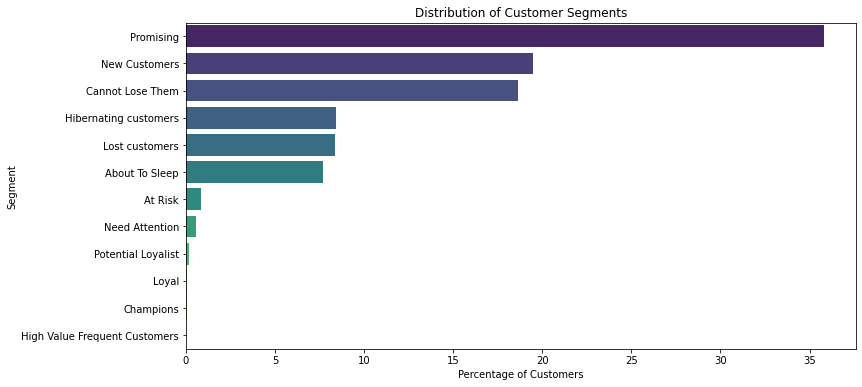

In [9]:
try:
    # Calculate the percentage of customers in each segment
    segment_counts = rfm_df['segment'].value_counts(normalize=True) * 100

    # Plot the distribution of segments
    plt.figure(figsize=(12, 6))
    sns.barplot(x=segment_counts.values, y=segment_counts.index, palette='viridis')
    plt.title('Distribution of Customer Segments')
    plt.xlabel('Percentage of Customers')
    plt.ylabel('Segment')
    plt.show()

except Exception as e:
    print("Error: Unable to plot segments.")
    print(e)

In [10]:
# Convert recency timedelta to number of days
rfm_df['recency_days'] = rfm_df['recency'].dt.days

In [11]:
from sqlalchemy import create_engine

# Define the database connection parameters
db_params = {
    "host": "localhost",
    "dbname": "Fp",       # Replace with your desired database name
    "user": "postgres",       # Replace with your PostgreSQL username
    "password": "admin",      # Replace with your PostgreSQL password
    "port": "5432"            # Replace with your PostgreSQL port
}

# Construct the SQLAlchemy connection string using db_params
connection_string = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}"

# Create the engine
engine = create_engine(connection_string)

In [12]:
try:
    rfm_df.to_sql('rfm_table', engine, if_exists='append', index=False)
    print("Data inserted into rfm_table successfully.")
except Exception as e:
    print("Error: Unable to save rfm_df as table.")
    print(e)

C:\Users\vig10\AppData\Local\Temp\ipykernel_34720\3536793429.py:2: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  rfm_df.to_sql('rfm_table', engine, if_exists='append', index=False)


Data inserted into rfm_table successfully.


In [13]:
# Add the 'recency_days' column
rfm_df['recency_days'] = rfm_df['recency'].dt.days

# Verify DataFrame structure
print("DataFrame structure and data:")
print(rfm_df.head())

try:
    # Establish a connection to the database
    with psycopg2.connect(
            host=db_config['host'],
            database=db_config['database'],
            user=db_config['user'],
            password=db_config['password'],
            port=db_config['port']) as conn:
        with conn.cursor() as cursor:
            # Check if the table already exists
            cursor.execute("SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_name = 'rfm_table')")
            table_exists = cursor.fetchone()[0]

            # If the table already exists, drop it
            if table_exists:
                cursor.execute("DROP TABLE rfm_table")
                conn.commit()
                print("Existing rfm_table dropped.")

            # Create a new table with the recency_days column
            cursor.execute("""
                CREATE TABLE rfm_table (
                    customer_unique_id VARCHAR(255),
                    recency INT,
                    frequency INT,
                    monetary FLOAT,
                    recency_score INT,
                    monetary_score INT,
                    frequency_score INT,
                    rfm_score VARCHAR(255),
                    segment VARCHAR(255),
                    recency_days INT
                );
            """)
            conn.commit()
            print("New rfm_table created.")

except Exception as e:
    print("Error during table creation:")
    print(e)

# Insert data using to_sql with detailed logging
try:
    print("Inserting data into rfm_table...")
    rfm_df.to_sql('rfm_table', engine, if_exists='append', index=False)
    print("Data inserted into rfm_table successfully.")

    # Verify data insertion
    with engine.connect() as conn:
        result = conn.execute("SELECT COUNT(*) FROM rfm_table")
        count = result.scalar()
        print(f"Number of rows in rfm_table: {count}")

except Exception as e:
    print("Error during data insertion:")
    print(e)

DataFrame structure and data:
                 customer_unique_id           recency  frequency  monetary  \
0  a46e277a383f4389ce5e0b642902c72c 278 days 01:15:49          1     22.77   
2  dd4d20c4fb1f0f3706d0e1e66b049a3f 372 days 03:15:01          1    604.62   
3  ed91e29ad9cf4fad5935469b0e91e792 128 days 11:22:55          1    873.91   
4  10b6d571eedd3e1bbf10521ee704dcd4 246 days 05:23:14          1     72.42   
5  f172e87cb8cd89e4e34bce37f28ce713 623 days 12:06:05          1     87.27   

  recency_score monetary_score  frequency_score rfm_score           segment  \
0             3              1                1       311     New Customers   
2             2              5                1       215  Cannot Lose Them   
3             5              5                1       515         Promising   
4             3              2                1       312    About To Sleep   
5             1              3                1       113  Cannot Lose Them   

   recency_days  
0       

C:\Users\vig10\AppData\Local\Temp\ipykernel_34720\1618476154.py:52: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  rfm_df.to_sql('rfm_table', engine, if_exists='append', index=False)


Data inserted into rfm_table successfully.
Number of rows in rfm_table: 1141888


In [14]:
# Drop the 'recency' column from the DataFrame
rfm_df.drop(columns=['recency'], inplace=True)

# Insert data using to_sql with detailed logging
try:
    print("Inserting data into rfm_table...")
    rfm_df.to_sql('rfm_table', engine, if_exists='append', index=False)
    print("Data inserted into rfm_table successfully.")

    # Verify data insertion
    with engine.connect() as conn:
        result = conn.execute("SELECT COUNT(*) FROM rfm_table")
        count = result.scalar()
        print(f"Number of rows in rfm_table: {count}")

except Exception as e:
    print("Error during data insertion:")
    print(e)

Inserting data into rfm_table...
Data inserted into rfm_table successfully.
Number of rows in rfm_table: 1237066


In [15]:
import pandas as pd

# Assuming rfm_df is your DataFrame that contains the RFM scores
rfm_df['rfm_score'] = rfm_df['rfm_score'].astype(str)  # Ensure rfm_score is a string

# Define segments based on RFM scores
segments = {
    # Existing segments
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers',
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions',
    r'335|345|355': 'High Value Frequent Customers',  # Updated label for these segments
}

# Create segment column based on the RFM score and defined segments
rfm_df['segment'] = rfm_df['rfm_score'].replace(segments, regex=True)

# Check the updated DataFrame to ensure segments are assigned correctly
print(rfm_df[['rfm_score', 'segment']].head(20))  # Print first 20 rows to verify


   rfm_score           segment
0        311     New Customers
2        215  Cannot Lose Them
3        515         Promising
4        312    About To Sleep
5        113  Cannot Lose Them
6        213    About To Sleep
7        314         Promising
8        213    About To Sleep
9        312    About To Sleep
10       515         Promising
11       214  Cannot Lose Them
12       215  Cannot Lose Them
13       112    Lost customers
14       411     New Customers
15       414         Promising
16       315         Promising
17       314         Promising
18       213    About To Sleep
19       512     New Customers
20       314         Promising


In [16]:
# Filter the DataFrame to show rows with rfm_score of 335
filtered_df = rfm_df[rfm_df['rfm_score'] == '335']

# Check the filtered DataFrame
print(filtered_df[['rfm_score', 'segment']])

      rfm_score                        segment
1616        335  High Value Frequent Customers
4294        335  High Value Frequent Customers
13646       335  High Value Frequent Customers
21709       335  High Value Frequent Customers
33302       335  High Value Frequent Customers
33349       335  High Value Frequent Customers
34911       335  High Value Frequent Customers
36341       335  High Value Frequent Customers
36428       335  High Value Frequent Customers
43535       335  High Value Frequent Customers
45015       335  High Value Frequent Customers
45298       335  High Value Frequent Customers
46883       335  High Value Frequent Customers
48154       335  High Value Frequent Customers
60532       335  High Value Frequent Customers
65041       335  High Value Frequent Customers
76678       335  High Value Frequent Customers
79485       335  High Value Frequent Customers
85966       335  High Value Frequent Customers
90433       335  High Value Frequent Customers
95062       3

In [17]:
# Verify that the segments are correctly updated in the DataFrame
print(rfm_df['segment'].value_counts())

Promising                        34064
New Customers                    18540
Cannot Lose Them                 17721
Hibernating customers             7994
Lost customers                    7977
About To Sleep                    7306
At Risk                            782
Need Attention                     542
Potential Loyalist                 156
Loyal                               39
Champions                           30
High Value Frequent Customers       27
Name: segment, dtype: int64


In [18]:
import psycopg2
from psycopg2 import sql

# Define your connection parameters
conn_params = {
    'dbname': 'postgres',
    'user': 'adminadmin',
    'password': 'InsightJDE03',
    'host': 'jde03.postgres.database.azure.com',
    'port': '5432'
}

# Establish a connection to the database
conn = psycopg2.connect(**conn_params)

# Create a cursor object
cursor = conn.cursor()

# Update the SQL database with the new segment values
try:
    update_query = sql.SQL("""
        UPDATE rfm_table 
        SET segment = data.segment
        FROM (VALUES %s) AS data(customer_unique_id, segment)
        WHERE rfm_table.customer_unique_id = data.customer_unique_id
    """)
    
    # Prepare data for batch update
    update_data = [(row['customer_unique_id'], row['segment']) for index, row in rfm_df.iterrows()]
    
    # Execute batch update
    psycopg2.extras.execute_values(cursor, update_query, update_data, template=None, page_size=100)
    
    conn.commit()
    print("Database successfully updated with new segment values.")
except psycopg2.Error as e:
    print("Error: Unable to update database.")
    print(e)
finally:
    # Close the cursor and connection
    cursor.close()
    conn.close()

Database successfully updated with new segment values.
